In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [4]:
data = pandas.read_csv('Data/hits.csv', index_col=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [5]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=100, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)
print len(event_ids_test)

100
570


# Tracks Reconstruction

In [6]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator, SuperCombinator
from retina import Retina2DTrackerTwo
from utils import get_sample_weight, plot_event


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [7]:
event = data[data.EventID == 3110]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values
sample_weight = get_sample_weight(event12)

In [8]:
sample_weight

array([ 0.33333333,  0.5       ,  0.33333333,  0.33333333,  0.33333333,
        0.5       ,  0.33333333,  0.5       ,  0.33333333,  0.33333333,
        0.33333333,  0.5       ,  0.5       ,  0.33333333,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ])

In [9]:
#%%time
rt = Retina2DTrackerTwo(n_tracks=2, residuals_threshold=0.7, sigma=0.7, min_hits=2)

rt.fit(x, y, sample_weight)

labels = rt.labels_
tracks_params = rt.tracks_params_

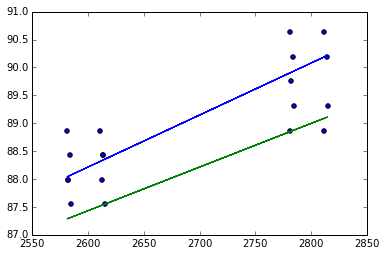

In [10]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [11]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [12]:
tracks_params

array([[  9.32675699e-03,   6.39643122e+01],
       [  7.82610592e-03,   6.70837651e+01]])

In [13]:
labels

array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0., -1.,  1.,  0.,  1.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.])

In [14]:
event12.Label.values

array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.])

# Train Classifier for the Tracks Combination

In [15]:
#%%time

from combination import SuperCombinator
from multiprocessing import Pool
from utils import merge_dicts, get_sample_weight

event_ids = event_ids_train
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = get_sample_weight(event12)
    weights34 = get_sample_weight(event34)
    
    # Select model for the tracks reconstruction
    stm_y = Retina2DTrackerTwo(n_tracks=2, residuals_threshold=0.3, sigma=0.7, min_hits=2)
    stm_stereo = Retina2DTrackerTwo(n_tracks=1, residuals_threshold=7, sigma=7, min_hits=2)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    return one_track

if __name__ == "__main__":
    p = Pool(4)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

In [16]:
# for i in event_ids:
#     print i
#     _=tracks_reconstruction(i)

In [17]:
sc = SuperCombinator()

combination_data = sc.data_collection(tracks, data)

X_data = combination_data[combination_data.columns[:-1]].values
y_data = combination_data.label.values

In [18]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
                             subsample=0.7, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 7.13 s, sys: 6.6 s, total: 13.7 s
Wall time: 11.4 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14'],
         n_folds=10, parallel_profile=None, random_state=11)

KFold prediction using folds column
KFold prediction using folds column
0.994949494949


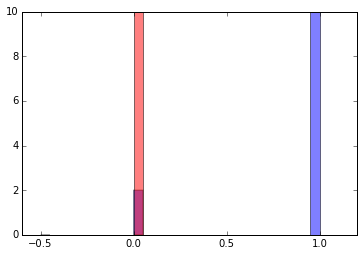

In [19]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

y_proba = y_predict

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

In [20]:
N = ((y_predict == y_data)*1).sum()
N_mis = ((y_predict != y_data)*1).sum()

print N, N_mis

396 2


### Tracks Reconstruction

In [21]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = event_ids_test
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = get_sample_weight(event12)
    weights34 = get_sample_weight(event34)
    
    # Select model for the tracks reconstruction
    stm_y = Retina2DTrackerTwo(n_tracks=2, residuals_threshold=0.4, sigma=0.7, min_hits=2)
    stm_stereo = Retina2DTrackerTwo(n_tracks=1, residuals_threshold=7, sigma=7, min_hits=2)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 37.9 ms, sys: 21.5 ms, total: 59.4 ms
Wall time: 16.1 s


In [22]:
#tracks_reconstruction(2)

In [59]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in event_ids_test:
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = SuperCombinator(classifier=folding.estimators[0])
    #comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 48.2 s, sys: 870 ms, total: 49.1 s
Wall time: 56.4 s


# Quality

# Stations 1&2

### Y-views

In [24]:
tracks_metrics_before_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.991049
RecoEff         0.994737
GhostRate       0.000000
CloneRate       0.005263
dtype: float64

### Stereo-views

In [25]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.989094
RecoEff         0.995614
GhostRate       0.001754
CloneRate       0.001754
dtype: float64

### Stations 1&2

In [26]:
tracks_metrics_before_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.989284
RecoEff         0.995614
GhostRate       0.000000
CloneRate       0.004386
dtype: float64

### Track efficiency

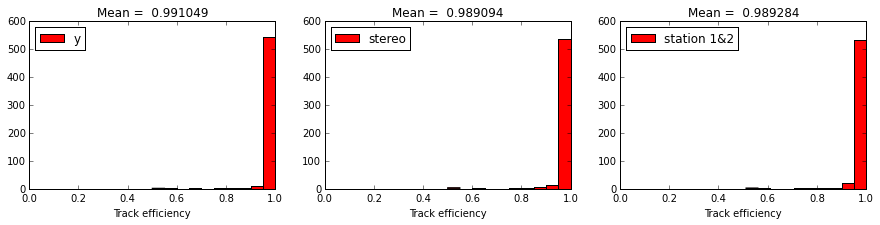

In [27]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

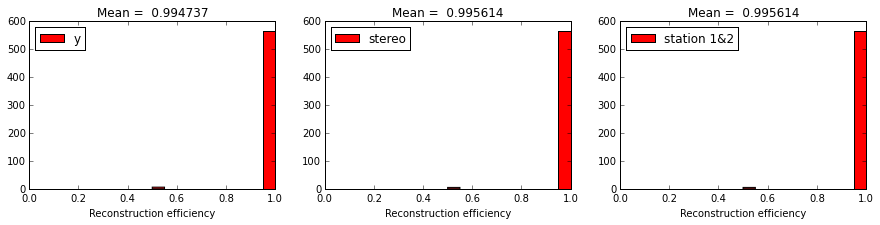

In [28]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [29]:
tracks_metrics_after_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.995052
RecoEff         0.992982
GhostRate       0.001754
CloneRate       0.004386
dtype: float64

### Stereo-views

In [30]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.993350
RecoEff         0.992105
GhostRate       0.001754
CloneRate       0.001754
dtype: float64

### Station 3&4

In [31]:
tracks_metrics_after_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.993809
RecoEff         0.992105
GhostRate       0.001754
CloneRate       0.005263
dtype: float64

### Tracks efficiency

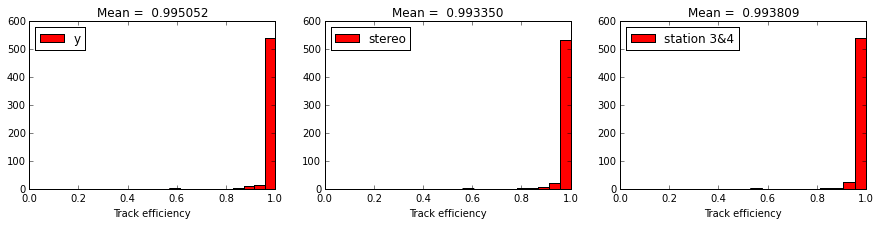

In [32]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

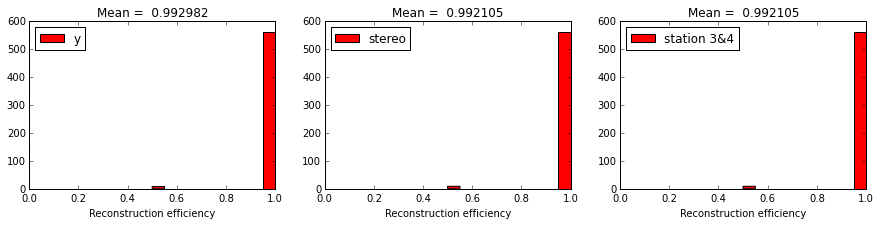

In [33]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [34]:
combinations_quality.mean(axis=0)

EventID      2567.573684
RecoEff         0.985088
GhostRate       0.013158
CloneRate       0.002632
NCombined       1.975439
dtype: float64

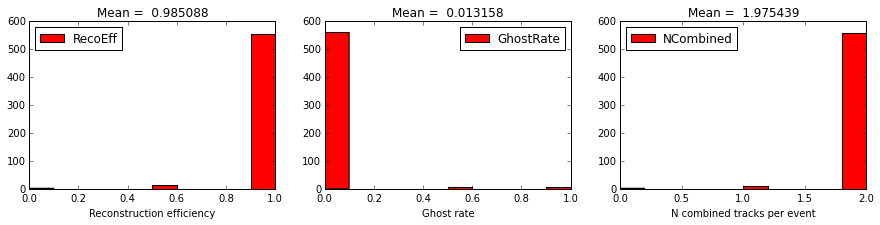

In [35]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

96.8421052632


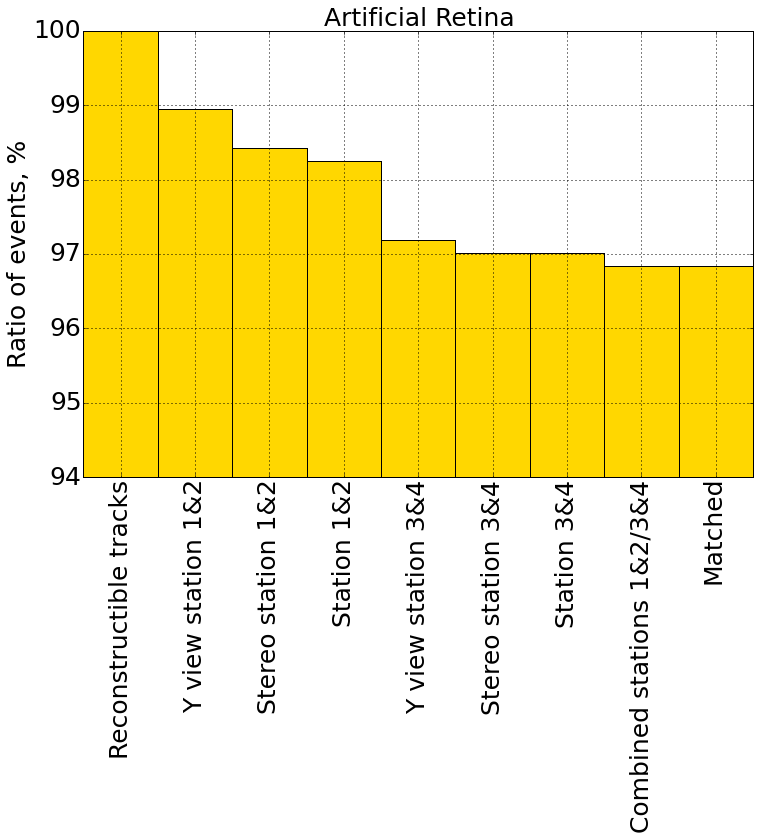

In [63]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(12,8))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.5, 8.5)
plt.ylim(94, 100)
#plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=25)
plt.grid(linewidth=1)
plt.title('Artificial Retina', size=25)
plt.show()

In [64]:
bar_values

array([ 100.        ,   98.94736842,   98.42105263,   98.24561404,
         97.19298246,   97.01754386,   97.01754386,   96.84210526,
         96.84210526])

In [76]:
#event_ids = numpy.unique(data.EventID.values)

def TotalEffVsTrackEff(event_ids, track_eff_cuts):

    total_efficiencies = []
    momentum_mae = []

    for cut in track_eff_cuts:

        combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                         'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

        pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                                'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

        for event_id in event_ids:

            # Get an event
            event = data[data.EventID == event_id]
            event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
            event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]


            labels12 = tracks[event_id]['labels12']
            tracks_params12 = tracks[event_id]['params12']
            labels34 = tracks[event_id]['labels34']
            tracks_params34 = tracks[event_id]['params34']

            # Quality metrics of the reconstruction
            trm12 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm12.fit(labels12, event12)

            # Quality metrics of the reconstruction
            trm34 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm34.fit(labels34, event34)

            # Combination of the tracks before and after the magnet
            comb = SuperCombinator(classifier=folding.estimators[0])
            comb.combine(tracks_params12, tracks_params34)


            # Quality of the combination
            cq = CombinatorQuality()
            cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)



            # Overall quality
            line = numpy.array([1, 
                                 (trm12.recognition_efficiency_y_ == 1)*1, 
                                 (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm12.recognition_efficiency_ == 1)*1,
                                 (trm34.recognition_efficiency_y_ == 1)*1, 
                                 (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm34.recognition_efficiency_ == 1)*1, 
                                 (cq.n_combined_ >= 2)*1,
                                 (cq.reco_eff_ == 1)*1]).cumprod()
            pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)

        bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
        bar_values = bar_values / bar_values[0] * 100

        total_eff = bar_values[-1]
        total_efficiencies.append(total_eff)

    total_efficiencies = numpy.array(total_efficiencies)

    return total_efficiencies

In [123]:
%%time
track_eff_cuts = numpy.linspace(0, 1., 51)
total_efficiencies = TotalEffVsTrackEff(event_ids, track_eff_cuts)

CPU times: user 9min 44s, sys: 29.6 s, total: 10min 14s
Wall time: 10min 30s


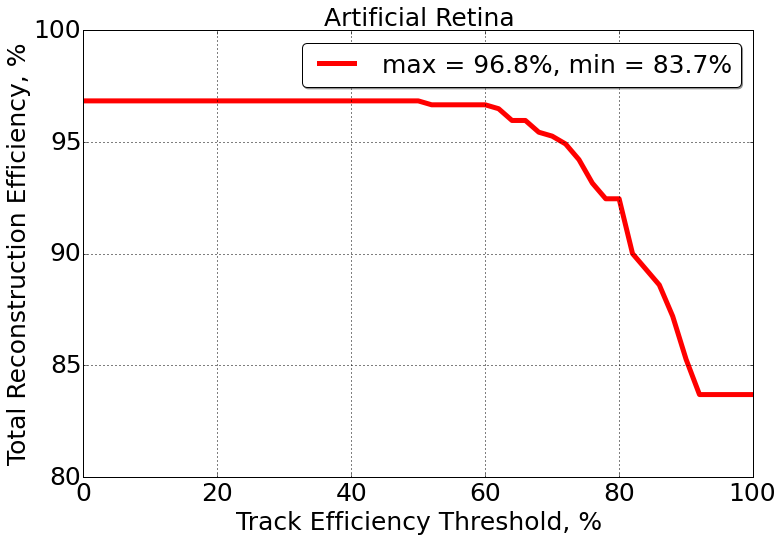

In [124]:
plt.figure(figsize=(12, 8))
l = 'max = ' + str(numpy.round(total_efficiencies[0], 1)) + '%, ' + 'min = ' + str(numpy.round(total_efficiencies[-1], 1)) + '%'
plt.plot(track_eff_cuts*100, total_efficiencies, linewidth=5, label=l)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
plt.title("Artificial Retina", fontsize=25)
plt.xlabel('Track Efficiency Threshold, %', fontsize=25)
plt.ylabel('Total Reconstruction Efficiency, %', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(80, 100)
plt.xlim(0., 100.)
plt.grid(linewidth=1)
plt.show()

In [79]:
total_efficiencies

array([ 96.84210526,  96.84210526,  96.84210526,  96.84210526,
        96.84210526,  96.84210526,  96.84210526,  96.84210526,
        96.84210526,  96.84210526,  96.84210526,  96.66666667,
        96.49122807,  95.96491228,  95.26315789,  94.21052632,
        92.45614035,  89.29824561,  85.26315789,  83.68421053,  83.68421053])

# Momentum

In [38]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

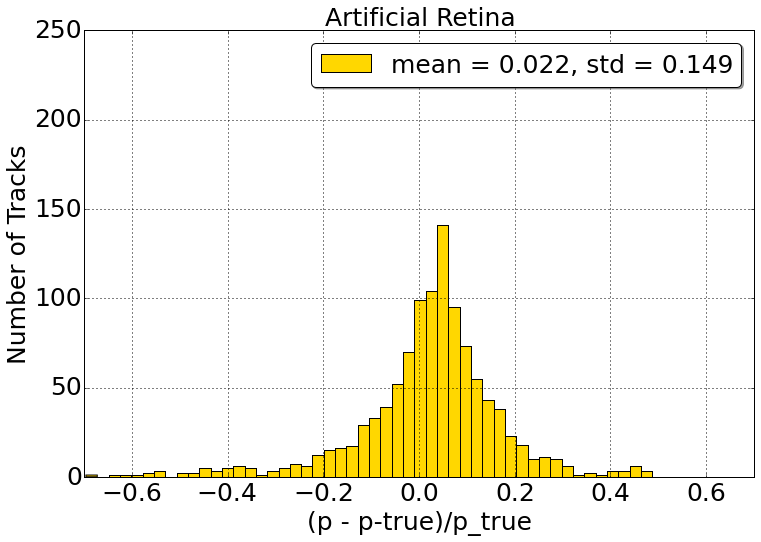

In [128]:
plt.figure(figsize=(12, 8))
q = -p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
l = 'mean = ' + str(numpy.round(q.mean(), 3)) + ', std = ' + str(numpy.round(q.std(), 3))
plt.hist(q, bins=50, normed=False, label=l, color='gold')
#plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('Artificial Retina', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
#plt.title("TrackEff vs RecoEff", fontsize=25)
plt.xlabel('(p - p-true)/p_true', fontsize=25)
plt.ylabel('Number of Tracks', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 250)
plt.xlim(-0.7, 0.7)
plt.grid(linewidth=1)
plt.show()

In [110]:
q = p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
q.mean(), q.std()

(-0.021869511194228593, 0.14852650793612379)

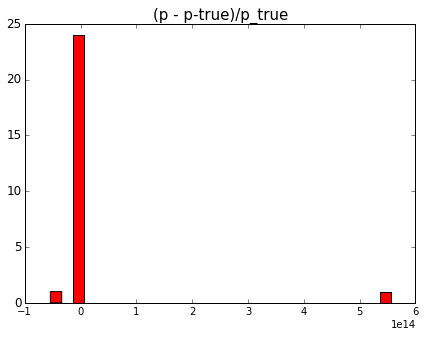

In [91]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)>0.5)], bins=30)
#plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
#plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
#plt.xlim(-0.5, 0.5)
plt.show()

In [87]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

6

In [41]:
print numpy.abs(p_err[numpy.isfinite(p_err)]).mean() * 100

5.53293379262e+13


In [42]:
120./570

0.21052631578947367

In [43]:
combinations_true[numpy.abs(combinations_true.PErr.values) >= 0.5 ]

,EventID,IsTrueCombination,PdgCode,Charge,IsTrueCharge,TruePInv,PErr,Label
21,670,1,-13,1,1,0.029773,8.953599e-01,1
24,2779,1,-13,1,1,0.011802,1.429266e+00,1
27,1724,1,-13,1,1,0.086879,6.263709e-01,1
44,2872,1,-211,-1,1,-0.022424,5.866180e-01,0
122,927,1,-211,-1,1,-0.015920,6.966004e-01,0
137,1023,1,13,-1,1,-0.026312,-6.231951e-01,1
155,1377,1,-211,-1,1,-0.015093,2.173493e+00,0
191,1637,1,-13,1,1,0.026257,5.574326e-01,1
292,3161,1,-13,1,1,0.014051,1.756032e+00,1
338,735,1,211,1,1,0.018522,5.508831e-01,0


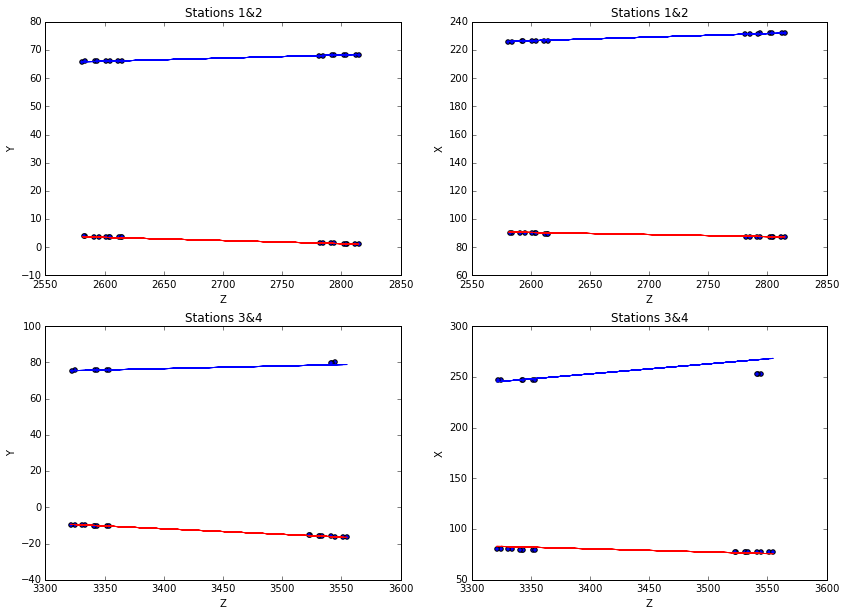

In [44]:
plot_event(670, data, tracks)

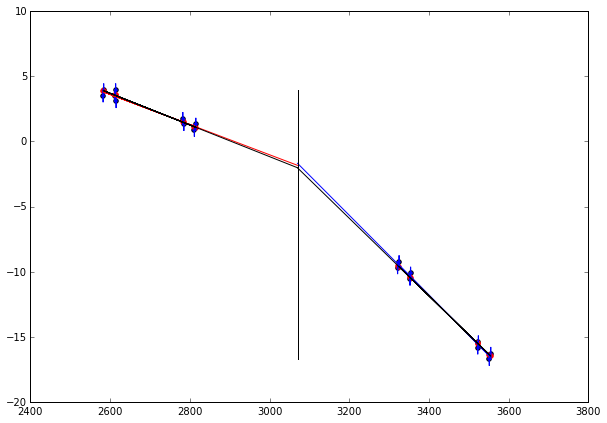

In [45]:
event = data[data.EventID == 670]
track = event[(event.ViewNb != 1)*(event.ViewNb != 2)*(event.Label == 0)]

track_before = track[(track.StatNb==1)+(track.StatNb==2)]
track_after = track[(track.StatNb==3)+(track.StatNb==4)]

k_before, b_before= numpy.polyfit(track_before.Wz1.values, track_before.Wy1.values, 1)
k_after, b_after = numpy.polyfit(track_after.Wz1.values, track_after.Wy1.values, 1)

k_before_true, b_before_true= numpy.polyfit(track_before.Z.values, track_before.Y.values, 1)
k_after_true, b_after_true = numpy.polyfit(track_after.Z.values, track_after.Y.values, 1)

from matplotlib.patches import Circle

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(track.Wz1.values, track.Wy1.values)
plt.scatter(track.Z.values, track.Y.values, color='r')

z_before = numpy.append(track_before.Wz1.values, [3070])
plt.plot(z_before, z_before * k_before + b_before)
plt.plot(z_before, z_before * k_before_true + b_before_true, color='0')

z_after = numpy.append(track_after.Wz1.values, [3070])
plt.plot(z_after, z_after * k_after + b_after)
plt.plot(z_after, z_after * k_after_true + b_after_true, color='0')

plt.plot([3070, 3070], [track.Wy1.values.min(), track.Wy1.values.max()], color='0')


for i, txt in enumerate(track.StrawNb.values):
    #plt.annotate(txt, (track.Wz1.values[i],track.Wy1.values[i]))
    e  = plt.Circle(xy=(track.Wz1.values[i],track.Wy1.values[i]), radius=0.5, color='b', fill=False)
    ax.add_patch(e)
    
    
plt.show()

# Efficiency per track

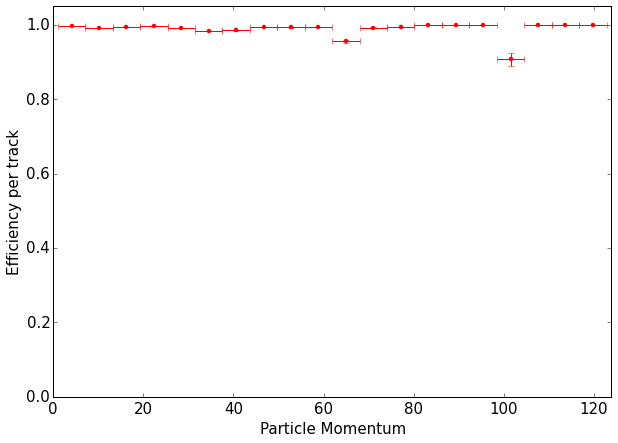

In [46]:
from utils import *

tracks_eff = get_effs_per_track_and_p(tracks, data, event_ids)

x_means, y_means, x_err, y_err = get_bins(tracks_eff.Momentum.values,
                                          tracks_eff.Eff.values,
                                          20,
                                          tracks_eff.Momentum.values.min(),
                                          tracks_eff.Momentum.values.max())

plt.figure(figsize=(10, 7))
plt.errorbar(x_means, y_means, xerr=x_err, yerr=y_err, fmt='none')
plt.scatter(x_means, y_means, linewidth=0, color='r')
plt.ylim(0.0, 1.05)
plt.xlim(0, x_means[-1]+x_err[-1]+1)
plt.xlabel('Particle Momentum', size=15)
plt.ylabel('Efficiency per track', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Did not recognized tracks

In [47]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
26,2040,1,0,0,0,0,0,0,0,0
69,1023,1,1,0,0,0,0,0,0,0
73,3085,1,0,0,0,0,0,0,0,0
84,4580,1,0,0,0,0,0,0,0,0
114,2277,1,0,0,0,0,0,0,0,0
116,1722,1,1,0,0,0,0,0,0,0
130,3253,1,0,0,0,0,0,0,0,0
132,1668,1,1,1,1,0,0,0,0,0
272,2762,1,1,1,1,1,0,0,0,0
292,1180,1,1,0,0,0,0,0,0,0


In [48]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

In [49]:
# for event_id in bad_events:
#     print event_id
#     plot_event(event_id, data, tracks)